<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_Detecci%C3%B3n_de_cardiopat%C3%ADa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Detección de cardiopatía

**Nombre**: Pablo Saavedra <br />
**Curso**: Modelos avanzados y Redes Neuronales (G105)


---

### Importación de librerías

In [94]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# AdaBoost y Gradient Boosting (scikit-learn)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# XGBoost (librería xgboost)
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def eval_model_short(name, model):
  y_pred = model.predict(X_test)
  # Para AUC necesitamos probas de clase 1
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

  print(f"{name:>18} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import mode


def bagging_het(X_train, y_train, T, estimators, X_test):
    """
    Crea un modelo Bagging usando estimadores heterogéneos.
    En que genera una cantidad T de muestras bootstrap y
    para cada una de ellas se entrena un estimador escogido
    en forma aleatoria desde la bolsa disponible.
    La estimación final usando los modelos entrenados se
    realiza por mayoría de votos.

    Basado en

    Parámetros:
    -----------
    X_train : DataFrame
        Conjunto de entrenamiento sin columna target.
    y_train : Series
        Datos con las clases asociadas a cada obs. de X_train
    T : int
        Representa la cantidad de muestras bootstrap a generar,
        equivalente a la cantidad de estimadores a entrenar.
    X_test : DataFrame
        Conjunto de test sobre el cual se somete el ensamble

    Retorna:
    --------
    list
        Lista con los estimadores entrenados

    np.array
        Array con cantidad de filas igual a la cantidad de
        observaciones de X_test y T columnas cada una con
        la clasificación predicha por el estimador asignado

    Series
        resultado por mayoría de votos para el conjunto de test

    list
        Lista con los índices no repetidos de las observaciones
        excluidad en cada muestra bootstrap
    """

    trained_model = []
    yhat_test = np.zeros((X_test.shape[0], T))
    idx_oob = []
    for t in np.arange(0, T):
        sa1 = X_train.sample(n=X_train.shape[0], replace=True)

        idx_oob = list(set(idx_oob + list(set(X_train.index)-set(sa1.index))))

        idx_estimator = np.random.randint(0, len(estimators))
        estimator = estimators[idx_estimator]
        #print(idx_estimator, end='; ')

        estimator.fit(sa1, y_train[sa1.index])
        trained_model.append(estimator)

        yhat_test[:,t] = estimator.predict(X_test)

    yhat_out = pd.Series(data=mode(yhat_test, axis=1)[0], name='yhat')

    return trained_model, yhat_test, yhat_out, idx_oob


def bagging_het_predict(X, estimators):
    yhat = np.zeros((X.shape[0], len(estimators)))

    for i, est in enumerate(estimators):
        yhat[:,i] = est.predict(X)

    return pd.Series(data=mode(yhat, axis=1)[0], name='yhat')

In [10]:
from typing import Optional, Iterable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def eval_model_preds(
    X_train, y_train,
    X_test,  y_test,
    y_pred_train,
    y_pred_test,
    class_names: Optional[Iterable[str]] = None,
    *,
    normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
    average: str = "weighted",           # "macro" | "weighted" | "micro"
    plot: bool = True,
    title_prefix: str = "",
    # scores para binario (p.ej. proba[:,1] o decision_function)
    pos_scores_train: Optional[np.ndarray] = None,
    pos_scores_test: Optional[np.ndarray] = None,
    binary_threshold: Optional[float] = None,  # si no None y hay scores, recalcula y_pred
    zero_division: int = 0,
    label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
    """
    Evalúa un clasificador en train/test con métricas y (opcional) gráficos,
    recibiendo predicciones ya calculadas (sin pasar el modelo).

    - y_pred_train/y_pred_test: predicción final (clase).
    - pos_scores_* (opcional): scores de clase positiva para AUC/ROC/PR (binario).
    """

    # ---------------------------
    # 0) Preparación / tipos
    # ---------------------------
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    y_pred_train = np.asarray(y_pred_train)
    y_pred_test  = np.asarray(y_pred_test)

    target_kind = type_of_target(y_test)
    is_binary = target_kind == "binary"

    # Si viene un mapeo explícito, aplícalo a y_* reales
    if label_map is not None:
        y_train = np.vectorize(label_map.get)(y_train)
        y_test  = np.vectorize(label_map.get)(y_test)

    # Si hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
    def _needs_alignment(y_true, y_pred):
        return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

    if _needs_alignment(y_test, y_pred_test):
        if not is_binary:
            raise TypeError(
                "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
                "Pasa 'label_map' o codifica etiquetas (LabelEncoder)."
            )
        if class_names is not None and len(list(class_names)) == 2:
            auto_map = {list(class_names)[0]: 0, list(class_names)[1]: 1}
            y_train = np.vectorize(auto_map.get)(y_train)
            y_test  = np.vectorize(auto_map.get)(y_test)
        else:
            uniq = list(np.unique(y_train))
            if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
                auto_map = {uniq[0]: 0, uniq[1]: 1}
                y_train = np.vectorize(auto_map.get)(y_train)
                y_test  = np.vectorize(auto_map.get)(y_test)
            else:
                raise TypeError(
                    "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                    "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
                )

    # ---------------------------
    # 1) Umbral binario (si aplica) usando scores
    # ---------------------------
    if is_binary and (pos_scores_train is not None or pos_scores_test is not None) and (binary_threshold is not None):
        thr = float(binary_threshold)
        if pos_scores_train is not None:
            y_pred_train = (np.asarray(pos_scores_train) >= thr).astype(int)
        if pos_scores_test is not None:
            y_pred_test  = (np.asarray(pos_scores_test)  >= thr).astype(int)

    # ---------------------------
    # 2) Métricas numéricas
    # ---------------------------
    metrics: Dict[str, Any] = {}

    def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )
        mcc = matthews_corrcoef(y_true, y_pred)
        return {
            f"{split}_accuracy": acc,
            f"{split}_balanced_accuracy": bacc,
            f"{split}_precision_{average}": p,
            f"{split}_recall_{average}": r,
            f"{split}_f1_{average}": f1,
            f"{split}_mcc": mcc
        }

    metrics.update(block_metrics(y_train, y_pred_train, "train"))
    metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

    # AUCs si tenemos scores (binario)
    if is_binary and (pos_scores_test is not None):
        try:
            if pos_scores_train is not None:
                metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
                metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
            metrics["test_roc_auc"] = roc_auc_score(y_test, pos_scores_test)
            metrics["test_pr_auc"]  = average_precision_score(y_test, pos_scores_test)
        except Exception:
            pass

    # ---------------------------
    # 3) Reportes por clase
    # ---------------------------
    prefix = (title_prefix + " ") if title_prefix else ""
    print(prefix + "Reporte de clasificación (train):")
    print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
    print(prefix + "Reporte de clasificación (test):")
    print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

    # ---------------------------
    # 4) Gráficos
    # ---------------------------
    if plot:
        has_scores = is_binary and (pos_scores_test is not None)
        fig, axes = (plt.subplots(2, 2, figsize=(10, 8)) if has_scores
                     else plt.subplots(1, 2, figsize=(10, 4)))
        axes = np.array(axes).flatten()

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_train, y_pred=y_pred_train,
            display_labels=class_names, normalize=normalize_cm, ax=axes[0]
        )
        axes[0].set_title(f"{title_prefix} Confusión (train)")

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_pred_test,
            display_labels=class_names, normalize=normalize_cm, ax=axes[1]
        )
        axes[1].set_title(f"{title_prefix} Confusión (test)")

        if has_scores:
            RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
            axes[2].set_title(f"{title_prefix} ROC (test)")

            PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
            axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

        plt.tight_layout()
        plt.show()

    return metrics


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', fontsize=10):
  '''
    plot_type: acepta valores in ['hist', 'boxplot']
  '''

  nrows = df.shape[1]//ncols
  if nrows*ncols < df.shape[1]:
    nrows += 1

  fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

  i = 0
  for idx, (colname, serie)  in enumerate(df.items()):
    j = (idx % ncols)

    ax[i,j].set_title(colname, fontsize=fontsize)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)

    if serie.unique().shape[0] <= max_discrete:

        serie = serie.value_counts().sort_values(ascending=True)

        ax_aux = ax[i,j].barh(
            y=np.array(serie.index).astype('str'),
            width=serie.values,
        )
    else:
        if plot_type == 'hist':
            ax[i,j].hist(x=serie, color='xkcd:tomato', density=True, alpha=0.7)
            ax[i,j].axvline(x=np.mean(serie), color='xkcd:black', ls='--', lw=0.8)
        elif plot_type == 'boxplot':
            ax[i,j].boxplot(serie)
            ax[i,j].set_xticklabels([''])

    if (j == ncols-1): i += 1

  plt.tight_layout()
  plt.show()


def plot_roc (X_test, y_test, lst_model, lst_model_name):

    plt.figure(figsize=(8, 6))
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    for idx, model in enumerate(lst_model):

        yhat_test_proba = model.predict_proba(X_test)[:, 1]

        # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
        fpr, tpr, umbrales = roc_curve(y_test, yhat_test_proba)

        # Calcular el área bajo la curva ROC (AUC)
        auc = np.round(roc_auc_score(y_test, yhat_test_proba), 4)

        # Plot de la curva ROC
        plt.plot(fpr, tpr, lw=1.5, label=f'{lst_model_name[idx]} AUC = {auc})')

    plt.legend(loc='lower right')
    plt.show()

## 1. Carga de datos

Carga los datos de los tres archivos unidos en un DataFrame, y prepáralos considerando las siguientes etapas:

a. asigna a la variable objetivo num un cero cuando su valor es cero, y un 1 en otro caso. Muestra la cantidad de valores ausente por atributo. Procésalos considerando los siguientes criterios:

  i. si el atributo presenta un porcentaje de valores ausentes mayor a 25%, entonces descartamos ese atributo.

  ii. para los atributos con valores ausentes menores al 25% se deben rellenar con el valor promedio del atributo de acuerdo a la clase, es decir, los valores ausentes para los cuales num=0 se deben rellenar con el promedio de los valores presentes para los cuales num=0.

  iii. Para las variables categóricas, los valores a asignar (promedio) deben ser aproximados al valor entero más cercano.

b. Construye variables dummies para las variables discretas con tres o más categorías.

c. Realiza un análisis descriptivo por variable visualizando histogramas y gráficos de barra según corresponda. Construye una matriz de correlaciones con un heatmap, para las variables continuas. Plantea tus observaciones y conclusiones

---

### Carga de datos

In [65]:
# Carga de datos
cols = pd.read_csv("/content/drive/MyDrive/Detección de cardiopatía/feature_names.csv", header=None).iloc[:, 0].tolist()

df1 = pd.read_csv("/content/drive/MyDrive/Detección de cardiopatía/processed.cleveland.data", header=None, names=cols)
df1 = df1.replace(",", ".", regex=True)
df1[:] = df1.apply(pd.to_numeric, errors="coerce")
df1['clinica'] = 1 # 1 cleveland

df2 = pd.read_csv("/content/drive/MyDrive/Detección de cardiopatía/processed.hungarian.data", header=None, names=cols)
df2 = df2.replace(",", ".", regex=True)
df2[:] = df2.apply(pd.to_numeric, errors="coerce")
df2['clinica'] = 2 # 2 hungarian

df3 = pd.read_csv("/content/drive/MyDrive/Detección de cardiopatía/processed.switzerland.data", header=None, names=cols)
df3 = df3.replace(",", ".", regex=True)
df3[:] = df3.apply(pd.to_numeric, errors="coerce")
df3['clinica'] = 3 # 3 switzerland

# Unir los datos en un solo dataframe
dfs = [df1, df2, df3]
df = pd.concat(dfs, ignore_index=True)

df = df.replace(",", ".", regex=True)
df[:] = df.apply(pd.to_numeric, errors="coerce")

# Variables
variables_cuantitativas = ["age", "threstbps", "chol", "thalach", "oldpeak"]
variables_cualitativas = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal", "clinica", "num"]

# a
df["num"] = df["num"].apply(lambda x: 0 if x == 0 else 1)

# a.i
for c in df.columns:
  if df[c].isnull().sum()/df.shape[0] >= 0.25:
    df.drop(c, axis=1, inplace=True)

# a.ii y a.iii
for c in df.columns:
  if c == "num":
    continue
  if df[c].isnull().sum()/df.shape[0] < 0.25:
    for clase in [0, 1]:
      filtro = df["num"] == clase
      media_filtrada = df.loc[filtro, c].mean()
      if c in variables_cualitativas:
        media_filtrada = round(media_filtrada)
      df.loc[filtro & df[c].isnull(), c] = media_filtrada

# b
cat_cols = [c for c in variables_cualitativas if c in df.columns and c != "num"]
df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          720 non-null    float64
 1   threstbps    720 non-null    float64
 2   chol         720 non-null    float64
 3   thalach      720 non-null    float64
 4   oldpeak      720 non-null    float64
 5   num          720 non-null    int64  
 6   sex_0.0      720 non-null    bool   
 7   sex_1.0      720 non-null    bool   
 8   cp_1.0       720 non-null    bool   
 9   cp_2.0       720 non-null    bool   
 10  cp_3.0       720 non-null    bool   
 11  cp_4.0       720 non-null    bool   
 12  fbs_0.0      720 non-null    bool   
 13  fbs_1.0      720 non-null    bool   
 14  restecg_0.0  720 non-null    bool   
 15  restecg_1.0  720 non-null    bool   
 16  restecg_2.0  720 non-null    bool   
 17  exang_0.0    720 non-null    bool   
 18  exang_1.0    720 non-null    bool   
 19  clinica_

/tmp/ipython-input-3190698101.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(",", ".", regex=True)


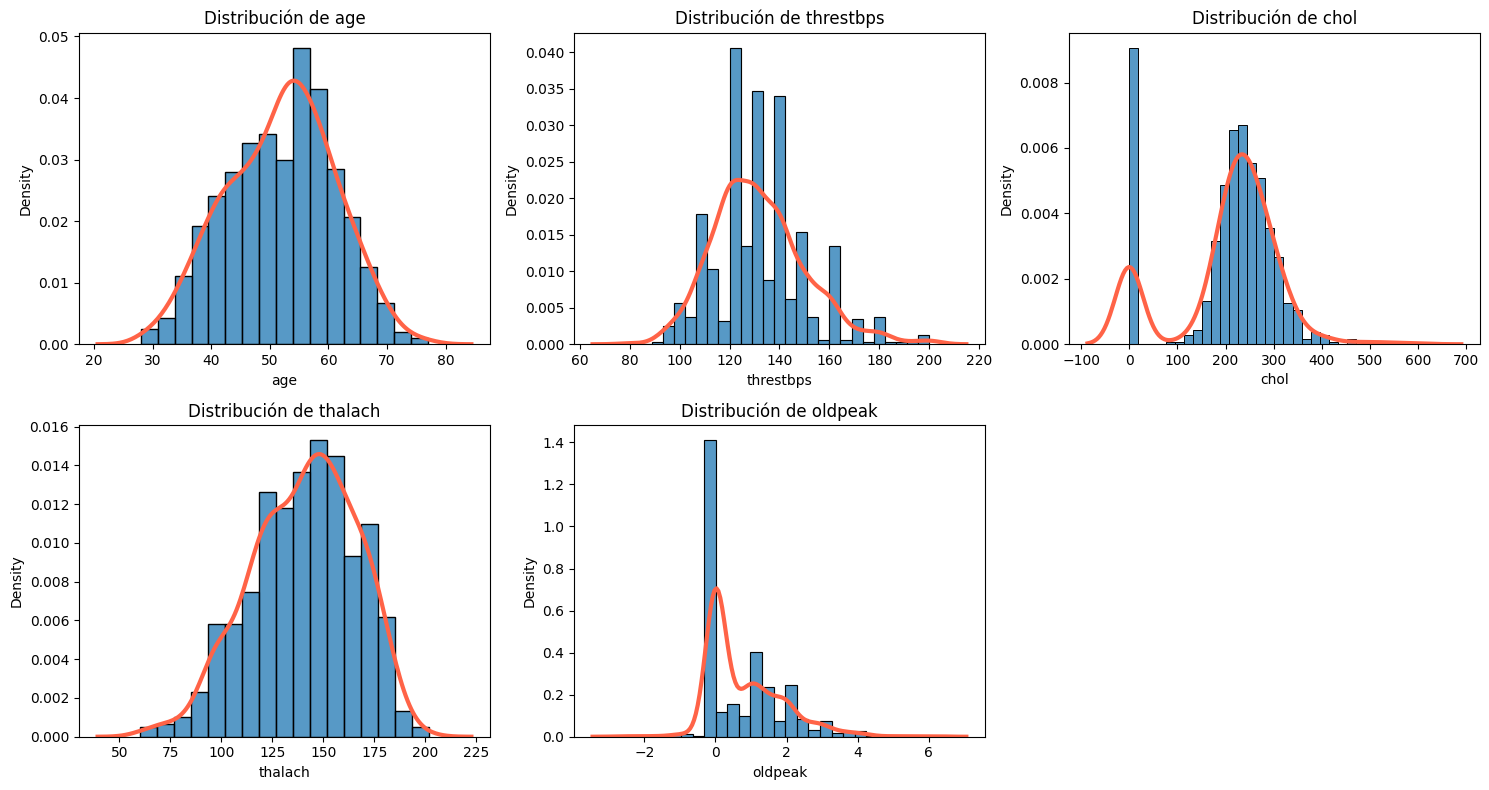

In [66]:
# c
plot_hist(df, variables_cuantitativas)

> - **age** (edad): distribución casi normal, concentrada aprox. entre 45–65 años, con pico cerca de 55.
> - **trestbps** (presión en reposo): concentrada entre 110–150, con sesgo a la derecha. Aparecen outliers altos llegando ~200+.
> - **chol** (colesterol): distribución asimétrica a la derecha con cola larga (valores muy altos); se ve un pico grande en 0. El grueso está aprox. entre 200–350.
> - **thalach** (frecuencia cardiaca máx.): forma cercana a normal, mayor densidad entre 120–180, pico cerca de 150; pocos extremos (<90 o >200).
> - **oldpeak** (depresión ST): muchos valores en 0 y fuerte sesgo a la derecha. La mayoría entre 0–2, con cola hasta ~6–7 (posibles outliers) y algunos valores negativos aislados.

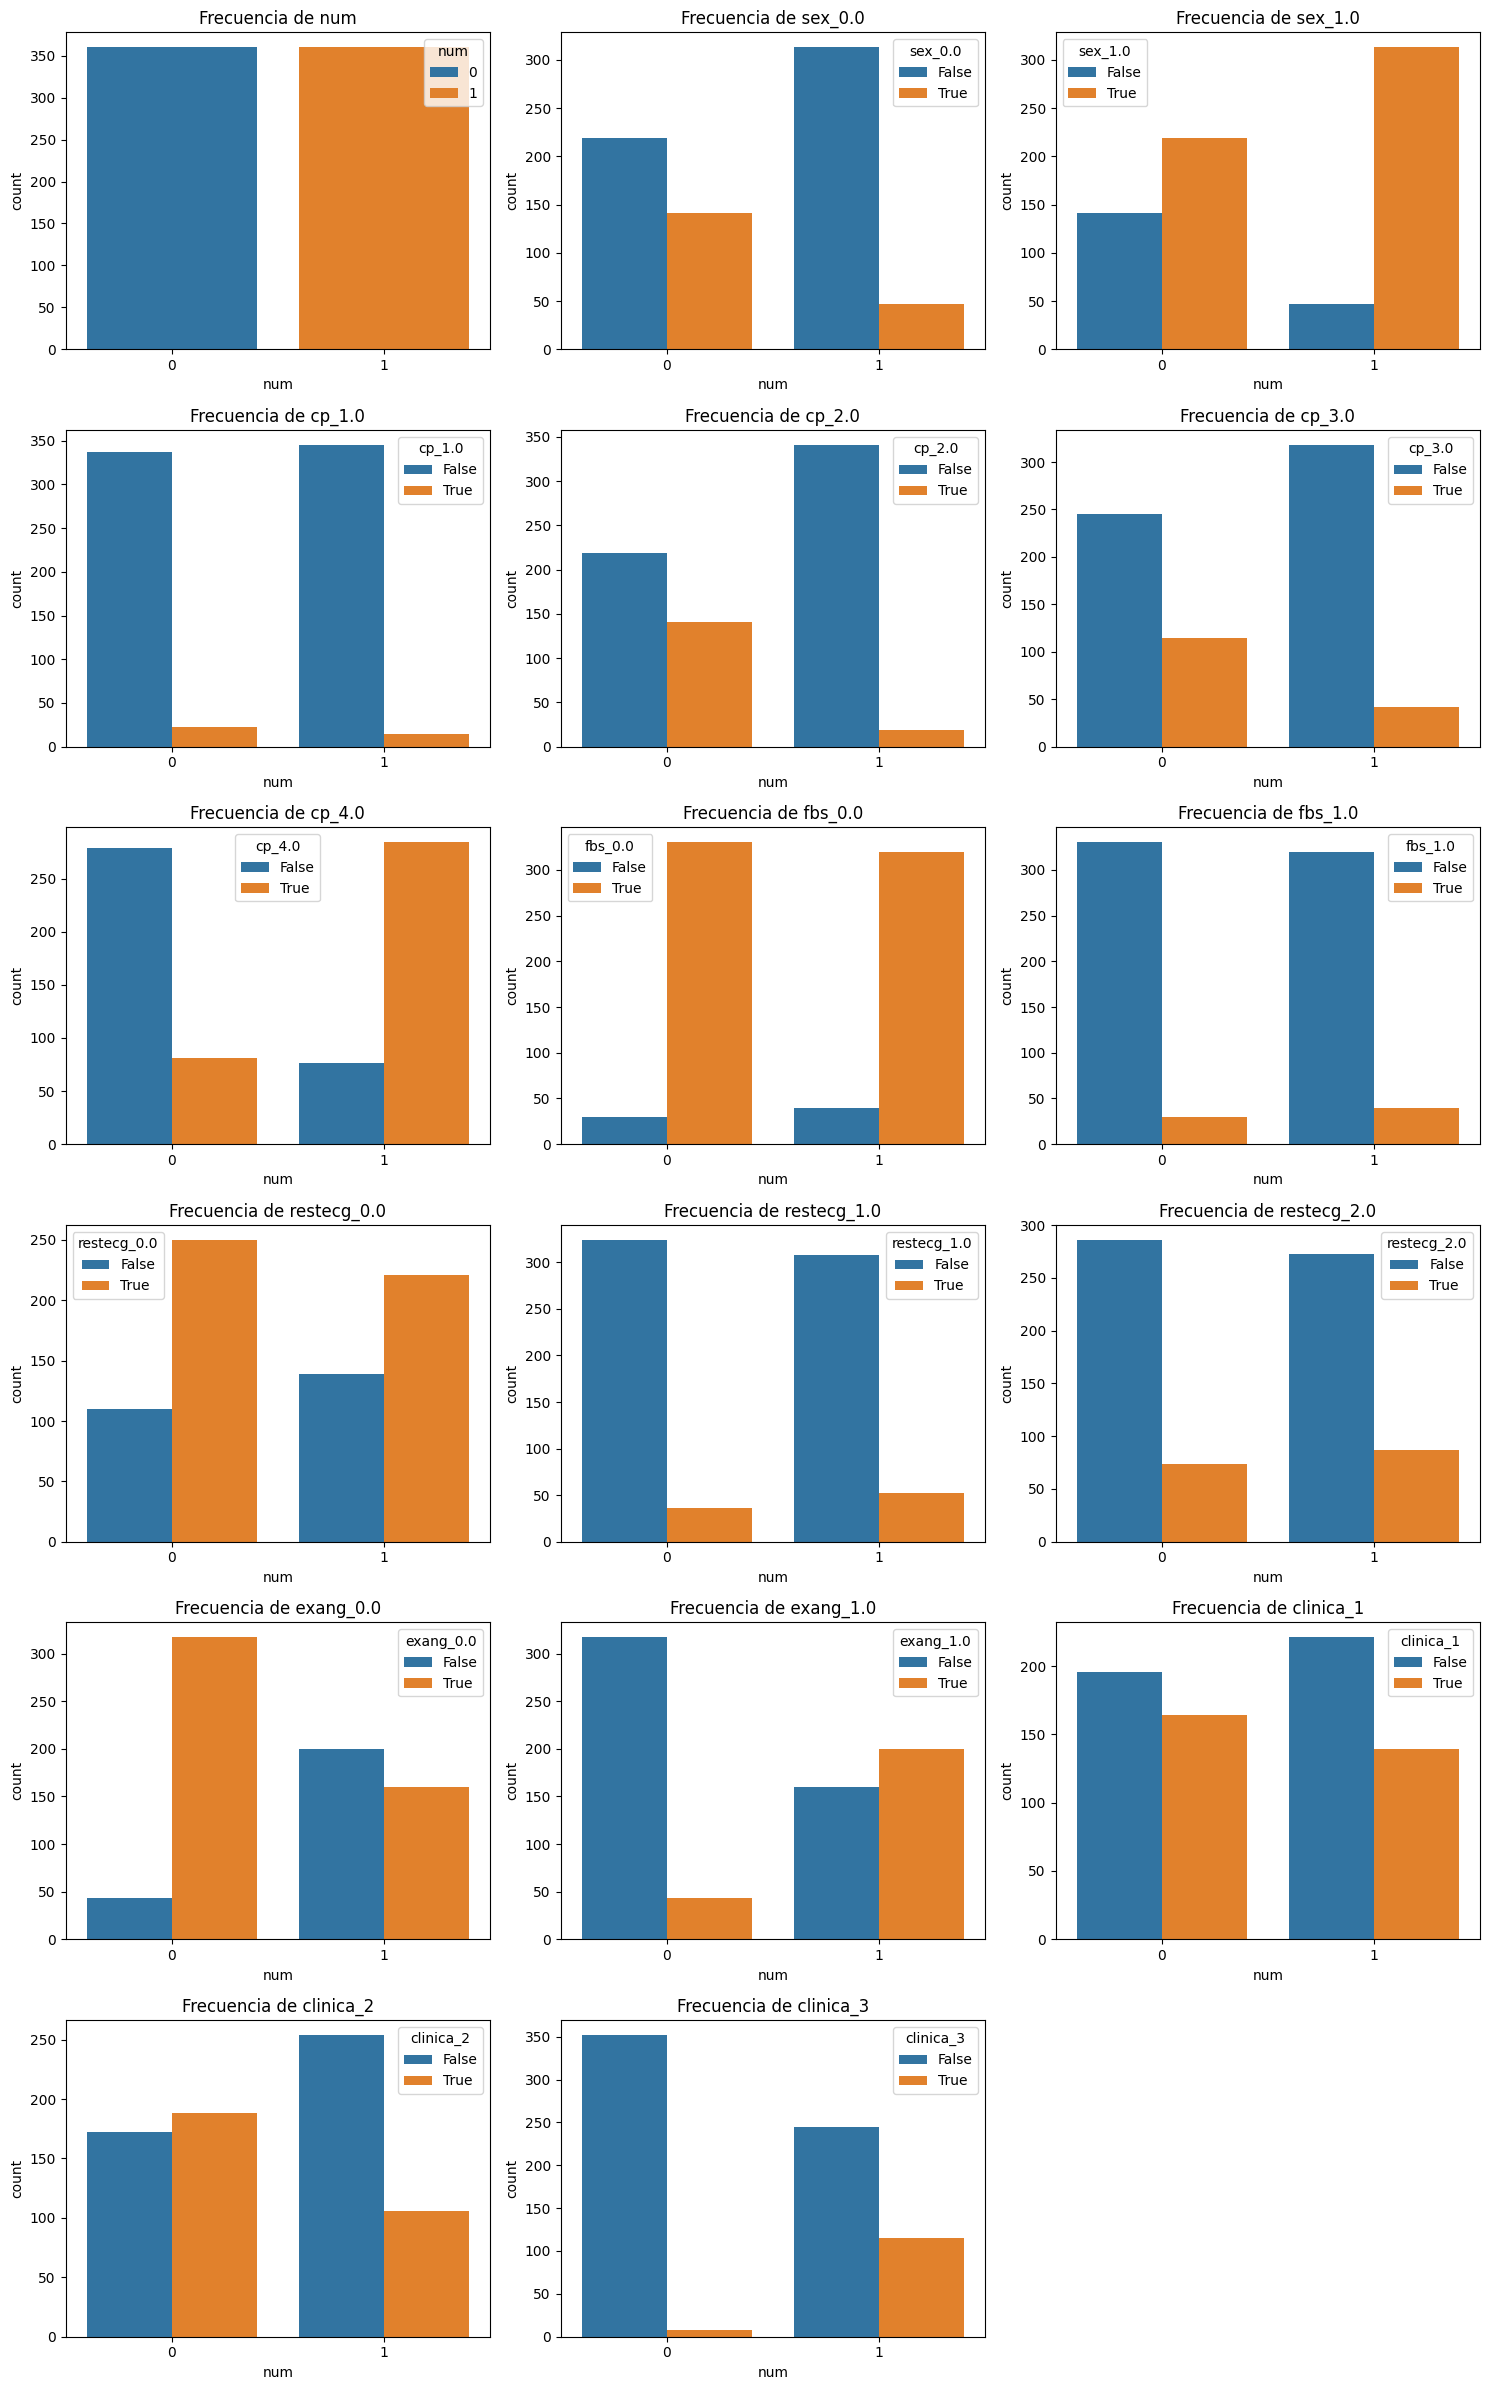

In [69]:
lista = [x for x in df.columns if x not in variables_cuantitativas]
plot_count(df, lista, _X='num')

> - **num** (target): clase balanceada (0 y 1 con frecuencias similares).
> - **Sexo**
>   - **sex_1.0** (True): aparece más cuando num = 1 y sugiere mayor proporción de esa categoría en casos positivos.
>   - **sex_0.0** (True): aparece más cuando num = 0 patrón inverso al anterior.
> - **Tipo de dolor de pecho** (cp)
>   - **cp_4.0** (True): muy asociado a num = 1 (diferencia grande) categoría fuertemente predictiva.
>   - **cp_2.0** (True) y **cp_3.0** (True): se ven más en num = 0 tienden a asociarse a la clase negativa.
>   - **cp_1.0** (True): poco frecuente y sin separación tan marcada.
> - **Azúcar en sangre en ayunas** (fbs)
>   - **fbs_1.0** (True): pocos casos y diferencias pequeñas entre num=0/1 baja señal.
>   - **fbs_0.0** (True): mayoría en ambos grupos (esperable, complementa a fbs_1.0).
> - **ECG en reposo** (restecg)
>   - **restecg_0.0** (True): es la categoría dominante en ambos grupos señal limitada.
>   - **restecg_1.0** (True): muy rara.
>   - **restecg_2.0** (True): algo más presente en num = 1 posible señal moderada.
> - **Angina inducida por ejercicio** (exang)
>   - **exang_1.0** (True): claramente más frecuente en num = 1 fuerte asociación.
>   - **exang_0.0** (True): claramente más frecuente en num = 0 patrón inverso.
> - **Clinica**
>   - **clinica_3** (True): casi solo aparece en num = 1 muy fuerte.
>   - **clinica_2** (True): más frecuente en num = 0 asociación negativa moderada.
>   - **clinica_1** (True): diferencias más pequeñas señal débil/moderada.

### Correlaciones

> Se calcula la correlación Pearson debido a que las variables son normales

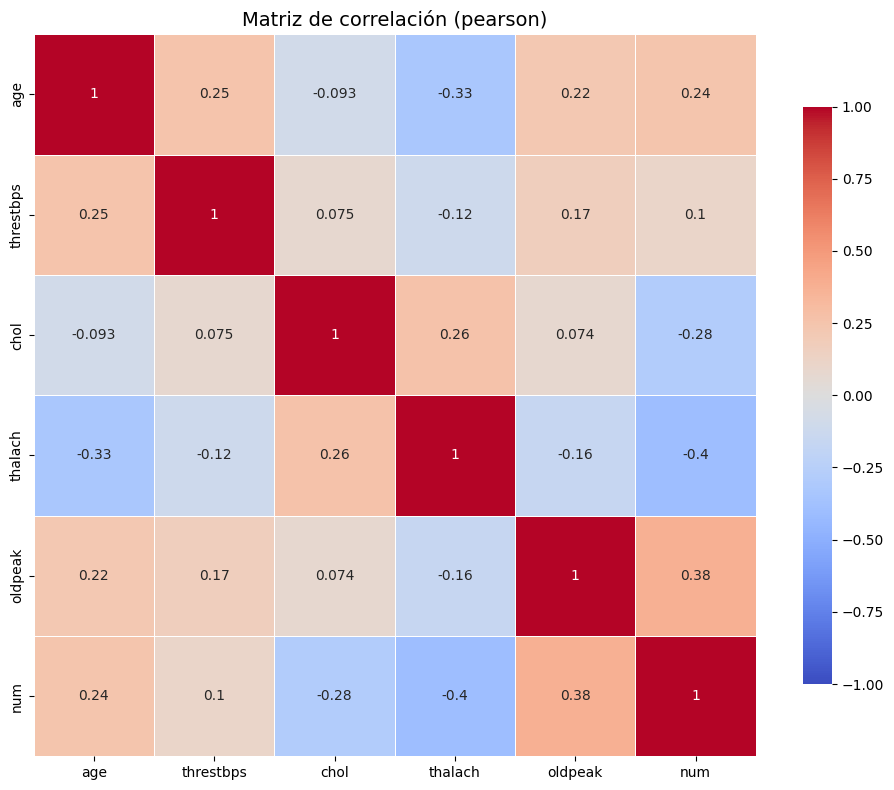

In [74]:
# Mostrar un gráfico con la matriz de correlación
lista = variables_cuantitativas.copy()
lista += ["num"]
plot_corr(df[lista], method="pearson",
    figsize=(10, 8), annot=True)

> **Correlación**:
> - num se asocia principalmente con thalach (correlación negativa, r≈−0.40) y oldpeak (positiva, r≈+0.38). chol y age tienen relación débil, y trestbps casi nula.

## 2. Árbol de Decisión

Divide la muestra en entrenamiento y test (33%), y con ello:

  a. entrena un modelo de ensamble secuencial AdaBoost

  b. entrena un modelo de ensamble secuencial Gradient Boosting
  
  c. entrena un modelo de ensamble secuencial XGBoosting

Para cada uno, utiliza hiper parámetros por defecto y muestra su desempeño usando las métricas adecuadas. Comenta.

---

In [75]:
# Separar data set en conjunto de entrenamiento y prueba
X = df.drop(columns=["num"])
y = df["num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=42
)

> Árbol de decisión, parámetros por defecto

In [89]:
# Entrenar Adaboost con parámetros por defecto
ada = AdaBoostClassifier(
    random_state=42
)
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [90]:
# Entrenar Gradient Boosting con parámetros por defecto
gb = GradientBoostingClassifier(
    random_state=42
)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [92]:
# Entrenar XGBoosting con parámetros por defecto
xgb = XGBClassifier(
    random_state=42
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [93]:
eval_model_short("AdaBoost", ada)
eval_model_short("GradBoost", gb)
eval_model_short("XGBoost", xgb)

          AdaBoost | ACC=0.849 | F1=0.847 | AUC=0.918
         GradBoost | ACC=0.836 | F1=0.834 | AUC=0.903
           XGBoost | ACC=0.811 | F1=0.803 | AUC=0.897


> El mejor modelo en este set es **AdaBoost**, porque lidera en las tres métricas (ACC 0.849, F1 0.847, AUC 0.918).
>
> **Gradient Boosting** queda segundo en desempeño general (menor ACC/F1 y el AUC más bajo).
>
> **XGBoost** es muy similar a Gradient Boosting, con AUC ligeramente mayor, pero peor ACC/F1, así que en este caso no supera a AdaBoost.

## 3. Adaboost

Realiza una búsqueda del hiper parámetro para el modelo que resulte tener mejor desempeño (utiliza f1-score para determinarlo). Los valores a buscar para la grilla son:

a. n_estimators: 20 a 200 con 15 valores

b. learning_rate: 0.004 a 1.0 con 40 valores

c. sub_sample: 0.1 a 1.0 con 18 valores

Muestra los mejores hiper parámetros encontrados y entrena un modelo con estos, presentando sus métricas.

---

In [95]:
# NOTA: "sub_sample" NO existe en AdaBoostClassifier (sklearn).
n_estimators_grid = np.linspace(20, 200, 15, dtype=int)      # 15 valores entre 20 y 200
learning_rate_grid = np.linspace(0.004, 1.0, 40)             # 40 valores entre 0.004 y 1.0

param_grid = {
    "n_estimators": n_estimators_grid,
    "learning_rate": learning_rate_grid
}

ada = AdaBoostClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor AUC CV:", grid.best_score_)



Mejores hiperparámetros: {'learning_rate': np.float64(0.9489230769230769), 'n_estimators': np.int64(32)}
Mejor AUC CV: 0.8332013634800013


In [96]:
best_ada = grid.best_estimator_

y_pred = best_ada.predict(X_test)
y_proba = best_ada.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"AdaBoost (tuned) | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

AdaBoost (tuned) | ACC=0.853 | F1=0.850 | AUC=0.915


Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.826     0.836     0.831       238
           1      0.838     0.828     0.833       244

    accuracy                          0.832       482
   macro avg      0.832     0.832     0.832       482
weighted avg      0.832     0.832     0.832       482

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.860     0.852     0.856       122
           1      0.846     0.853     0.850       116

    accuracy                          0.853       238
   macro avg      0.853     0.853     0.853       238
weighted avg      0.853     0.853     0.853       238



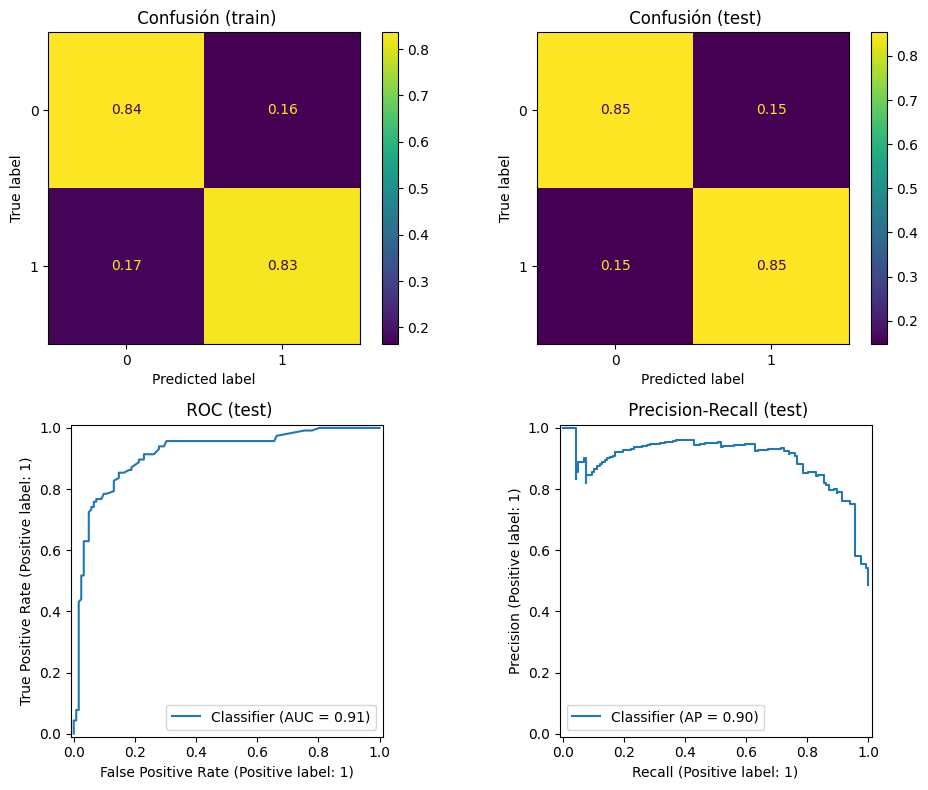

In [102]:
# Evaluar modelo Bagging
ada_metricas = eval_model(
    best_ada, X_train, y_train, X_test, y_test)

In [103]:
ada_metricas

{'train_accuracy': 0.8319502074688797,
 'train_balanced_accuracy': np.float64(0.8320016531202645),
 'train_precision_weighted': 0.832027685473735,
 'train_recall_weighted': 0.8319502074688797,
 'train_f1_weighted': 0.8319567178024043,
 'train_mcc': np.float64(0.6639518585960366),
 'test_accuracy': 0.8529411764705882,
 'test_balanced_accuracy': np.float64(0.8529536461277558),
 'test_precision_weighted': 0.8529972701095696,
 'test_recall_weighted': 0.8529411764705882,
 'test_f1_weighted': 0.8529541631732437,
 'test_mcc': np.float64(0.7057826243117855),
 'train_roc_auc': np.float64(0.9210290673646507),
 'test_roc_auc': np.float64(0.9148530243075185),
 'train_pr_auc': np.float64(0.9308888377510398),
 'test_pr_auc': np.float64(0.8958394458714467)}

> El modelo muestra buen desempeño y buena generalización:
> - En test logra buenas métricas:
>   - **Accuracy/Balanced Accuracy** ≈ 0.853
>   - **F1** ≈ 0.853
>   - **MCC** ≈ 0.706.
> - La capacidad discriminativa es alta: ROC-AUC ≈ 0.915 y PR-AUC ≈ 0.896 en test.
> - La brecha train vs test es pequeña (AUC 0.921 → 0.915; F1 0.832 → 0.853), por lo que no se observa sobreajuste importante; incluso el test queda ligeramente mejor.

## 4. Comparar curvas ROC

Elabora un gráfico con las curvas ROC para cada modelo entrenado, y a partir de ello recomienda alguno de ellos. Justifica la decisión

---

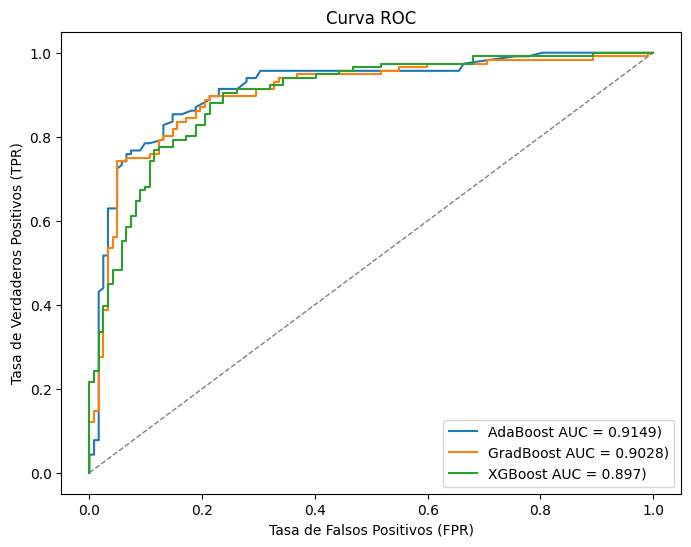

In [104]:
# Estimadores
plot_roc(X_test, y_test, [best_ada, gb, xgb], ["AdaBoost", "GradBoost", "XGBoost"])

> - Los tres superan claramente al azar al estar todos los modelos por encima de la diagonal del gráfico de la curva ROC.
> - AdaBoost es el mejor según la ROC (AUC≈0.915), seguido de Gradient Boosting (≈0.903) y XGBoost (≈0.897).

## 5. Nivel de importancia

Muestra las variables por nivel de importancia para el mejor modelo, luego de la búsqueda de hiper parámetro. Comenta.

---

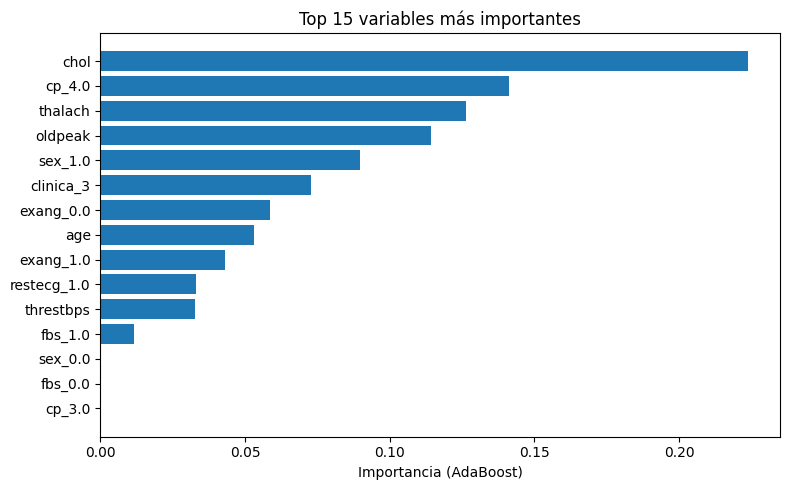

In [99]:
model = best_ada

# Importancias
imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Top N (ajusta a gusto)
top_n = 15
imp_top = imp.head(top_n)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(imp_top.index, imp_top.values)
plt.xlabel("Importancia (AdaBoost)")
plt.title(f"Top {top_n} variables más importantes")
plt.tight_layout()
plt.show()

In [105]:
imp_top

,0
cp_3.0,0.00
fbs_0.0,0.00
sex_0.0,0.00
fbs_1.0,0.01
threstbps,0.03
restecg_1.0,0.03
exang_1.0,0.04
age,0.05
exang_0.0,0.06
clinica_3,0.07


> Conclusiones:
> - El colesterol (chol) es la variables más importante para el modelo AdaBoost. Seguido de dolor toráxico asintomático (cp_4.0), Frecuencia cardiaca máxima (thalach), Despresión ST (oldpeak) y el sexo (en hombres).
> - La variable clínica generada a partir del origen de los datos también ayudó, aunque se puede deber a que la clínica tenga más casos de cancer que los demás y eso ayude a predecir.

>